## Import libraries

In [37]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings("ignore")

## Load models and data

In [38]:
# loading data
X_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_train_balanced.npy"
)
y_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_train_balanced.npy"
)
X_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_test.csv"
)
y_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_test.csv"
)

In [39]:
# Load encoders
with open("/home/samir-dahal/Diabetes_Classification/models/encoders.pkl", "rb") as f:
    encoders = pickle.load(f)
    class_encoder = encoders["class_encoder"]
y_test_decoded = class_encoder.inverse_transform(y_test)


In [40]:
# Load XGBoost Model
with open(
    "/home/samir-dahal/Diabetes_Classification/models/classification/xgboost.pkl", "rb"
) as f:
    xgb_model = pickle.load(f)


In [41]:
xgb_predictions = xgb_model.predict(X_test)
xgb_predictions_decoded = class_encoder.inverse_transform(xgb_predictions)
xgb_correct = y_test.values.flatten() == xgb_predictions

print("\nXGBoost Model Loaded")
print(f"  Accuracy: {xgb_correct.mean() * 100:.2f}%")
print(f"  Errors: {(~xgb_correct).sum()}/{len(y_test)}")


XGBoost Model Loaded
  Accuracy: 99.48%
  Errors: 1/193


In [42]:
# Load K-Means Model
with open(
    "/home/samir-dahal/Diabetes_Classification/models/clustering/kmeans_model.pkl", "rb"
) as f:
    kmeans_model = pickle.load(f)


In [43]:
# Create cluster-to-label mapping
train_clusters = kmeans_model.predict(X_train_balanced)
cluster_to_label = {}
for cluster_id in np.unique(train_clusters):
    mask = train_clusters == cluster_id
    most_common_label = pd.Series(y_train_balanced[mask]).mode()[0]
    cluster_to_label[cluster_id] = most_common_label

In [44]:
# Predict on test set
test_clusters = kmeans_model.predict(X_test)
kmeans_predictions = np.array([cluster_to_label[c] for c in test_clusters])
kmeans_predictions_decoded = class_encoder.inverse_transform(kmeans_predictions)
kmeans_correct = y_test.values.flatten() == kmeans_predictions

print("\nK-Means Model Loaded")
print(f"  Accuracy: {kmeans_correct.mean() * 100:.2f}%")
print(f"  Errors: {(~kmeans_correct).sum()}/{len(y_test)}")



K-Means Model Loaded
  Accuracy: 87.05%
  Errors: 25/193


## Error Analysis

In [45]:
# Create error analysis dataframe
error_df = pd.DataFrame(
    {
        "True_Label": y_test_decoded,
        "XGBoost_Prediction": xgb_predictions_decoded,
        "KMeans_Prediction": kmeans_predictions_decoded,
        "XGB_Correct": xgb_correct,
        "KMeans_Correct": kmeans_correct,
    }
)

# Add error type classification
conditions = [
    (error_df["XGB_Correct"]) & (error_df["KMeans_Correct"]),
    (~error_df["XGB_Correct"]) & (error_df["KMeans_Correct"]),
    (error_df["XGB_Correct"]) & (~error_df["KMeans_Correct"]),
    (~error_df["XGB_Correct"]) & (~error_df["KMeans_Correct"]),
]
choices = ["Both Correct", "Only XGB Wrong", "Only KMeans Wrong", "Both Wrong"]
error_df["Error_Type"] = np.select(conditions, choices, default="Unknown")

print("Error Analysis DataFrame Created:")
print(error_df["Error_Type"].value_counts())

Error Analysis DataFrame Created:
Error_Type
Both Correct         168
Only KMeans Wrong     24
Both Wrong             1
Name: count, dtype: int64


## Error Distribution

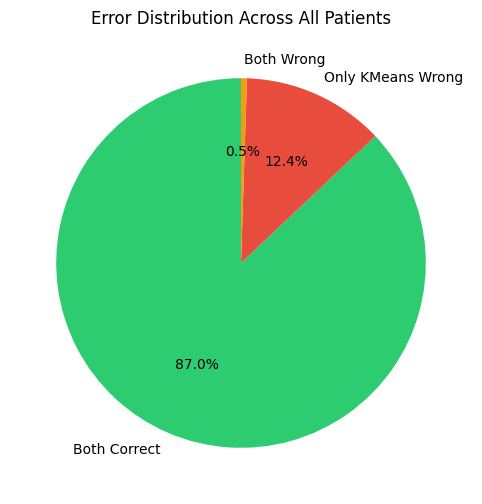

In [46]:
# Error Distribution Pie Chart
plt.figure(figsize=(8, 6))

error_counts = error_df["Error_Type"].value_counts()
colors = ["#2ecc71", "#e74c3c", "#f39c12", "#8e44ad"]

plt.pie(
    error_counts.values,
    labels=error_counts.index,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
)
plt.title("Error Distribution Across All Patients")
plt.show()

## Model Accuracy Comparison

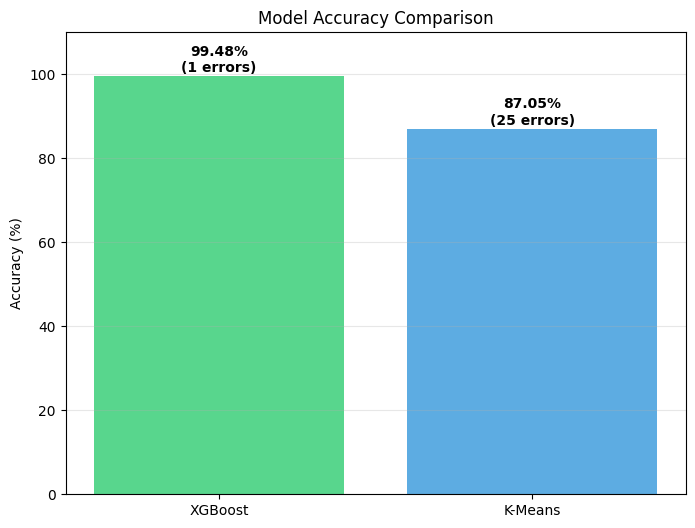

In [47]:
# Model Accuracy Comparison
models = ["XGBoost", "K-Means"]
accuracies = [xgb_correct.mean() * 100, kmeans_correct.mean() * 100]
error_counts = [(~xgb_correct).sum(), (~kmeans_correct).sum()]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=["#2ecc71", "#3498db"], alpha=0.8)

# Add labels on bars
for bar, acc, err in zip(bars, accuracies, error_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{acc:.2f}%\n({err} errors)",
        ha="center",
        fontweight="bold",
    )

plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 110)
plt.grid(axis="y", alpha=0.3)
plt.show()